In [2]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

import warnings
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
# Load in data from csv file
df = pd.read_csv('../input/bi1x_2015_c_elegans_optogenetics.csv', comment='#')

# Take a look
df.head()


,Group,Worm,WT,AVA,ASH
0,Group B1,worm 1,0,1,1
1,Group B1,worm 2,0,1,0
2,Group B1,worm 3,0,1,0
3,Group B2,worm 1,0,1,0
4,Group B2,worm 2,0,1,0


In [5]:
#tidy it up
df= pd.melt(df, id_vars=['Group', 'Worm'],\
            value_vars=['WT', 'AVA', 'ASH'], value_name= \
           'reversal', var_name= 'strain')
df.head()

,Group,Worm,strain,reversal
0,Group B1,worm 1,WT,0
1,Group B1,worm 2,WT,0
2,Group B1,worm 3,WT,0
3,Group B2,worm 1,WT,0
4,Group B2,worm 2,WT,0


In [12]:
def revs_trials(df, strain):
    """
    Return number of reversals and number of trials
    """
    inds= (df['strain'] == strain) & (df['reversal'] >= 0)
    n_r= df[inds]['reversal'].sum()
    n= df[inds]['reversal'].count()
    
    return n_r, n

In [8]:
def log_posterior(n_r, n, p):
    """
    Log posterior of reversal measurements
    """
    #remember n! = gamma(n+1)
    return scipy.special.gammaln(n+2) - scipy.special.gammaln(n_r+1)\
            - scipy.special.gammaln(n-n_r+1) + n_r*np.log(p)\
            + (n-n_r)*np.log(1-p)

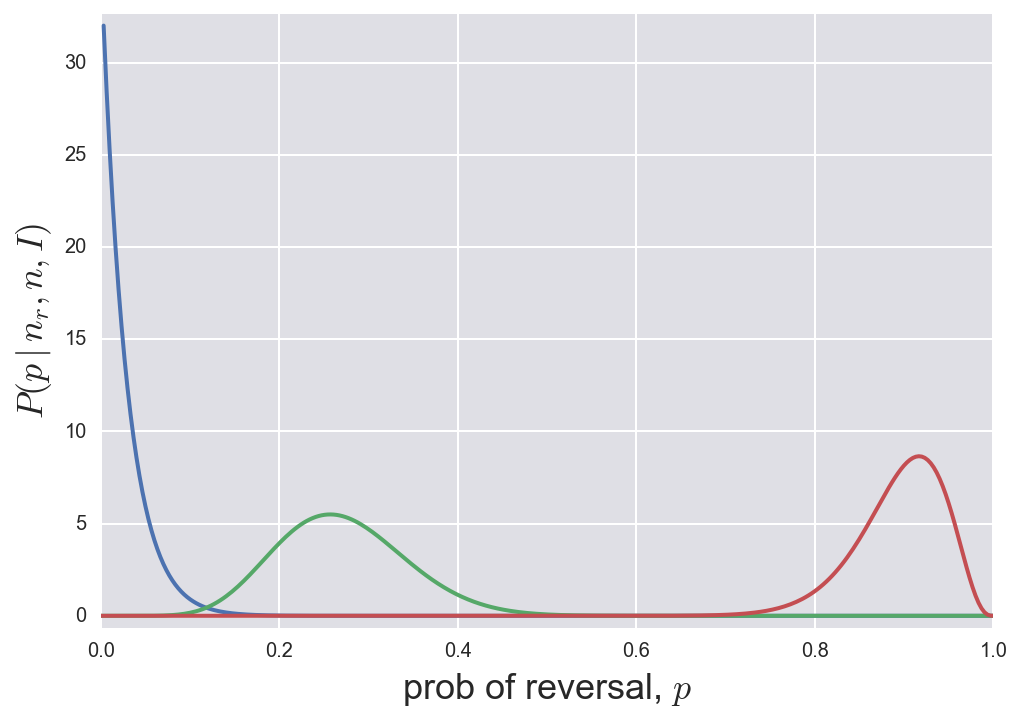

In [15]:
#Plot the posterior for all three strains
p= np.linspace(0, 1, 300)

#make plots
strains= ['WT', 'ASH', 'AVA']

for strain in strains:
    n_r, n= revs_trials(df, strain)
    plt.plot(p, np.exp(log_posterior(n_r, n, p)), '-')
    
#prettify
plt.margins(y = 0.02)
plt.xlabel('prob of reversal, $p$')
plt.ylabel(r'$P(p\mid n_r, n, I)$')

# Find $$\delta = p_1-p_2; \gamma = p_1+p_2$$ Change of variables in the posterior, $$P(p_1, p_2\mid D, I) --> P(\delta, \gamma \mid D, I)$$ and use a numerical integrator to calculate the new posterior since it looks really nasty.

In [18]:
def posterior_delta_gamma(delta, gamma, n_r1, n_1, n_r2, n_2):
    """
    Posterior probability distribution for delta and gamma
    Input is arrays delta and gammas, returns a 2d array for
    various values of gamma
    """
    
    #Make 2D versions of delta and gamma
    dd, gg= np.meshgrid(delta, gamma)
    
    #first outlawed values of n_r and n
    if n_r1 > n_1 or n_r2 > n_2:
        return np.zeros_like(dd)
    
    #Initialize output array
    out= np.empty_like(dd)
    
    #Populate zero values based on outlawed deltas and gammas
    out[abs(dd) > 1]= 0
    out[gg < 0]= 0
    out[(gg <= abs(dd))]= 0
    out[(gg >= (2-abs(dd)))]= 0
    
    #get indices with nonzero values
    inds= (out != 0)
    
    #compute log prob
    log_P= scipy.special.gammaln(n_1+2) - scipy.special.gammaln(n_r1+1)\
    + scipy.special.gammaln(n_2+2) - scipy.special.gammaln(n_r2+1)\
    - scipy.special.gammaln(n_1-n_r1+1)\
    -scipy.special.gammaln(n_2-n_r2+1)\
    + n_r1*np.log((gg[inds] - dd[inds])/2) \
    +n_r2*np.log((gg[inds]+dd[inds])/2)\
    + (n_1-n_r1)*np.log(1-(gg[inds]-dd[inds])/2)\
    + (n_2-n_r2)*np.log(1-(gg[inds]+dd[inds])/2)
    
    
    #populate and return
    out[inds]= np.exp(log_P)/2
    
    return out

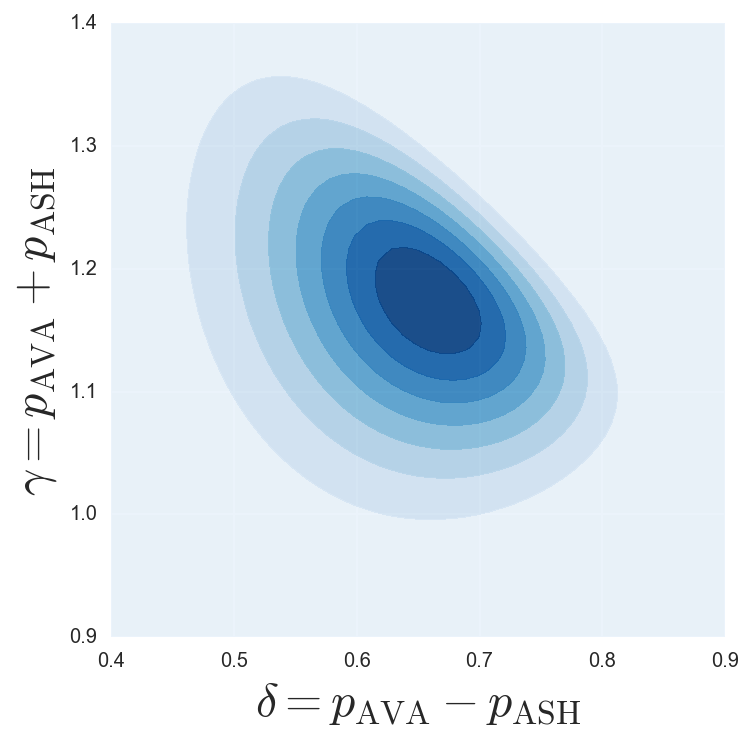

In [19]:
#generate plot
gamma= np.linspace(0, 2, 200)
delta= np.linspace(-1, 1, 200)

#make coordinate for contour plot
dd, gg= np.meshgrid(delta, gamma)

#compute probabilities
n_r_ash, n_ash= revs_trials(df, 'ASH')
n_r_ava, n_ava= revs_trials(df, 'AVA')

post= posterior_delta_gamma(delta, gamma, n_r_ash, n_ash, n_r_ava, n_ava)

#plot the contour
plt.contourf(dd, gg, post, cmap= plt.cm.Blues, alpha= 0.7)
plt.contourf(dd, gg, post, cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\delta = p_\mathrm{AVA} - p_\mathrm{ASH}$', fontsize=24)
plt.ylabel(r'$\gamma = p_\mathrm{AVA} + p_\mathrm{ASH}$', fontsize=24)
plt.xlim((0.4, 0.9))
plt.ylim((0.9, 1.4))
plt.axes().set_aspect('equal', adjustable='box')


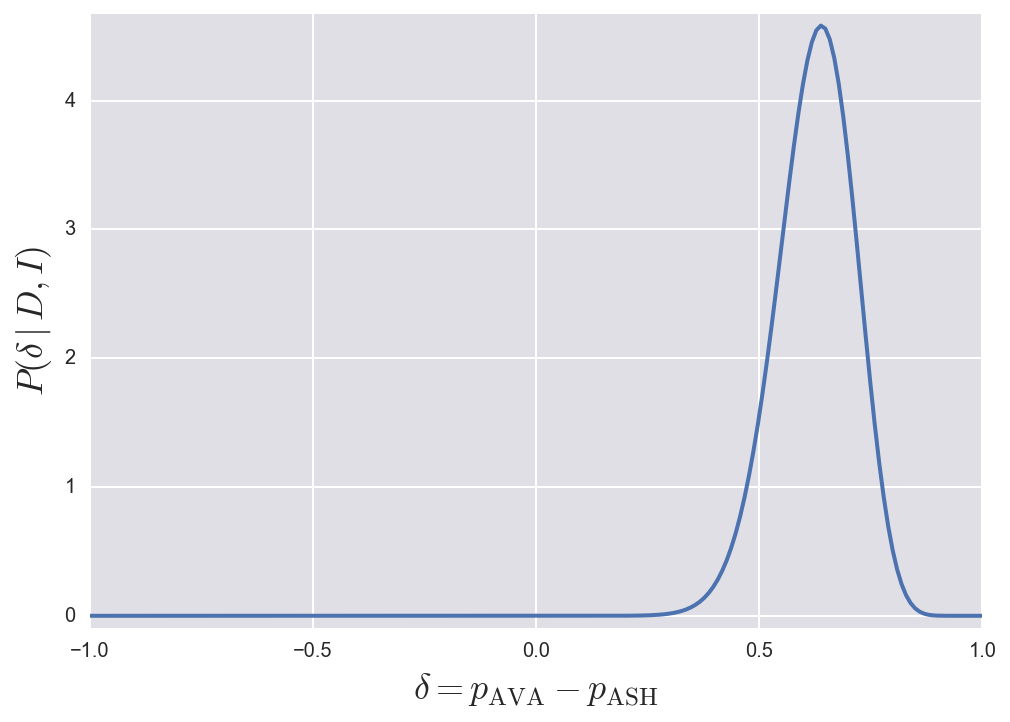

In [20]:
# Integrate over gamma
post_delta = np.trapz(post, x=gamma, axis=0)

# Plot the distribution of delta 
plt.plot(delta, post_delta, '-')
plt.xlabel(r'$\delta = p_\mathrm{AVA} - p_\mathrm{ASH}$')
plt.ylabel(r'$P(\delta \mid D, I)$')
plt.margins(y=0.02)


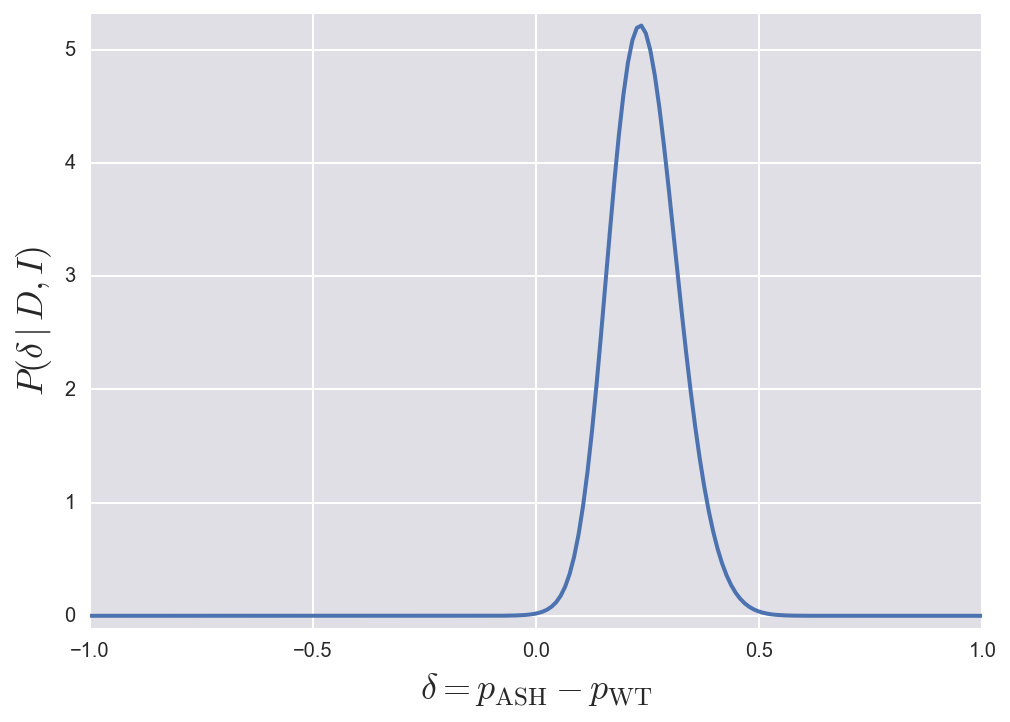

In [21]:
# Generate gamma and delta for the plot
gamma = np.linspace(0, 2, 200)
delta = np.linspace(-1, 1, 200)

# Make coordinates for contour plots
dd, gg = np.meshgrid(delta, gamma)

# Compute probability
n_r_ash, n_ash = revs_trials(df, 'WT')
n_r_ava, n_ava = revs_trials(df, 'ASH')
post = posterior_delta_gamma(delta, gamma, n_r_ash, n_ash, n_r_ava, n_ava)

# Integrate over gamma
post_delta = np.trapz(post, x=gamma, axis=0)

# Plot the distribution of delta 
plt.plot(delta, post_delta, '-')
plt.xlabel(r'$\delta = p_\mathrm{ASH} - p_\mathrm{WT}$')
plt.ylabel(r'$P(\delta \mid D, I)$')
plt.margins(y=0.02)


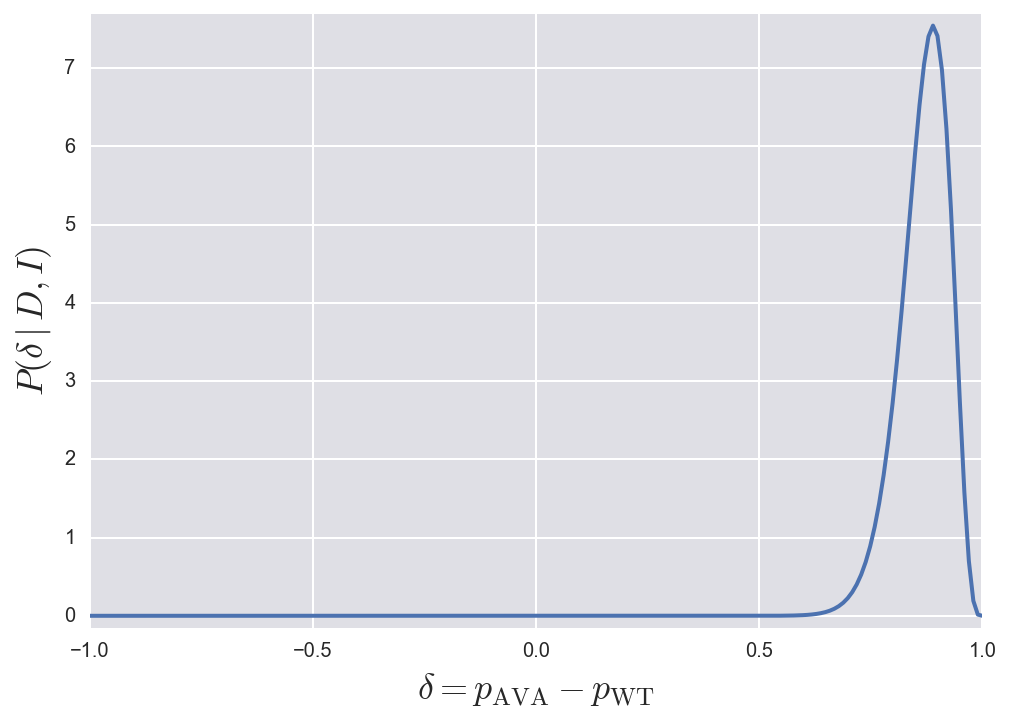

In [22]:
# Generate gamma and delta for the plot
gamma = np.linspace(0, 2, 200)
delta = np.linspace(-1, 1, 200)

# Make coordinates for contour plots
dd, gg = np.meshgrid(delta, gamma)

# Compute probability
n_r_ash, n_ash = revs_trials(df, 'WT')
n_r_ava, n_ava = revs_trials(df, 'AVA')
post = posterior_delta_gamma(delta, gamma, n_r_ash, n_ash, n_r_ava, n_ava)

# Integrate over gamma
post_delta = np.trapz(post, x=gamma, axis=0)

# Plot the distribution of delta 
plt.plot(delta, post_delta, '-')
plt.xlabel(r'$\delta = p_\mathrm{AVA} - p_\mathrm{WT}$')
plt.ylabel(r'$P(\delta \mid D, I)$')
plt.margins(y=0.02)
